# Lending Club Case Study

### Importing required libraries

In [218]:
import pandas as pd
import numpy as np
import re
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Getting error saying to set low_memory=False or use dtype to save memory. Used low_memory=False

In [219]:
df = pd.read_csv('/Users/ejanjanam/Downloads/loan.csv', low_memory=False)
df.dtypes

id                              int64
member_id                       int64
loan_amnt                       int64
funded_amnt                     int64
funded_amnt_inv               float64
                               ...   
tax_liens                     float64
tot_hi_cred_lim               float64
total_bal_ex_mort             float64
total_bc_limit                float64
total_il_high_credit_limit    float64
Length: 111, dtype: object

### Subtract 100 from years if the year is greater than current year as the datetime is considering only 21st century dates

In [220]:
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], format='%b-%y')
    df.loc[df[col].dt.year > datetime.now().year, col] -= pd.DateOffset(years=100)

### Check how many columns are completely null

In [221]:
len(df.columns[df.isnull().all()])

54

### Dropping all null columns

In [222]:
all_null_columns = df[df.columns[df.isnull().all()]].columns
df = df.drop(columns=all_null_columns)
df.shape

(39717, 57)

### Check percentage of null values in remaining columns

In [223]:
(df.isnull().mean() * 100).round(2)

id                             0.00
member_id                      0.00
loan_amnt                      0.00
funded_amnt                    0.00
funded_amnt_inv                0.00
term                           0.00
int_rate                       0.00
installment                    0.00
grade                          0.00
sub_grade                      0.00
emp_title                      6.19
emp_length                     2.71
home_ownership                 0.00
annual_inc                     0.00
verification_status            0.00
issue_d                        0.00
loan_status                    0.00
pymnt_plan                     0.00
url                            0.00
desc                          32.59
purpose                        0.00
title                          0.03
zip_code                       0.00
addr_state                     0.00
dti                            0.00
delinq_2yrs                    0.00
earliest_cr_line               0.00
inq_last_6mths              

### Dropping columns having more than 60% null values as they don't contribute much useful insights

In [224]:
cols_with_60_per_nulls = df.columns[(df.isnull().mean() * 100).round(2) > 60]
df = df.drop(columns=cols_with_60_per_nulls)
df.shape

(39717, 54)

### Check for unique values

In [225]:
unique_cols = []
for column in df.columns:
    if(df[column].nunique() == 1):
        unique_cols.append(column)
unique_cols

['pymnt_plan',
 'initial_list_status',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'tax_liens']

### Drop columns having single value as the constant values does not help in analysis

In [226]:
df = df.drop(columns=unique_cols)
df.shape

(39717, 45)

In [227]:
df['emp_title'].value_counts()

emp_title
US Army                              134
Bank of America                      109
IBM                                   66
AT&T                                  59
Kaiser Permanente                     56
                                    ... 
Community College of Philadelphia      1
AMEC                                   1
lee county sheriff                     1
Bacon County Board of Education        1
Evergreen Center                       1
Name: count, Length: 28820, dtype: int64

In [228]:
df['desc'].value_counts()

desc
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           210
Debt Consolidation                                                                                                                                                                  

### The spread of emp_title and desc is more and we cannot get much useful information from these columns

In [229]:
df = df.drop(columns=['emp_title', 'desc'])
df.shape

(39717, 43)

### Imputing values for columns ['emp_length', 'title', 'revol_util', 'pub_rec_bankruptcies', 'last_pymnt_d', 'last_credit_pull_d'] as there is noticeable difference in max repeating value to remaining values

In [230]:
impute_cols = ['emp_length', 'title', 'revol_util', 'pub_rec_bankruptcies', 'last_pymnt_d', 'last_credit_pull_d']

for col in impute_cols:
    most_repeat_val = df[col].value_counts().idxmax()
    df[col] = df[col].fillna(most_repeat_val)

df.isnull().sum()

id                         0
member_id                  0
loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
grade                      0
sub_grade                  0
emp_length                 0
home_ownership             0
annual_inc                 0
verification_status        0
issue_d                    0
loan_status                0
url                        0
purpose                    0
title                      0
zip_code                   0
addr_state                 0
dti                        0
delinq_2yrs                0
earliest_cr_line           0
inq_last_6mths             0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_inv            0
total_rec_prnc

### Converting 'pub_rec_bankruptcies' to integer

In [231]:
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].astype(int)

### Trunating '%' and 'year(s)' from 'int_rate' and 'emp_length'

In [232]:
df['int_rate'] = df['int_rate'].apply(lambda x: pd.to_numeric(x.split("%")[0]))
df['revol_util'] = df['revol_util'].apply(lambda x: pd.to_numeric(x.split("%")[0]))
df['emp_length'] = df['emp_length'].apply(lambda x: 0 if x == '< 1 year' else int(re.sub(r'\D', '', x)))

### Creating Derived metrics from loan issue date, last payment date and credit history length

In [233]:
# date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']

df['issue_month'] = df['issue_d'].dt.month.astype(int)
df['issue_year'] = df['issue_d'].dt.year.astype(int)

df['last_pay_month'] = df['last_pymnt_d'].dt.month.astype(int)
df['last_pay_year'] = df['last_pymnt_d'].dt.year.astype(int)

current_date = datetime.now()
df['credit_history_length'] = ((current_date - df['earliest_cr_line']).dt.days / 365.25).astype(int)

## Seggregating remaining columns
### Extra Columns:
- __id__: It is numerical column which is not related to loan_status
- __member_id__: It is borrower member id and it is not related to loan_status
- __funded_amnt__: It is mostly equal to loan_amnt and it gives same info as loan_amnt
- __funded_amnt_inv__: It is also mostly equal to loan_amnt and it gives same info as loan_amnt
- __sub_grade__: 'grade' gives necessary info and sub grade is more granular which is not required
- __url__: It is unique address which is there for all loan and does not help in analysis
- __title__: The spread of title is more and we can get sufficient info from purpose
- __zip_code__: The spread of zip_code is also more and we can get info from addr_state
- __inq_last_6mths__: Most of the customers had 0 to 2 inquries for both fully paid and charged off
- __open_acc__: Both fully paid and Charged Off customers are usually having 5 to 10 acccounts mostly
- __revol_util__: Both fully paid and Charged Off customers are having more utilization in 60% to 100%
- __total_acc__: This also follows same pattern as open_acc ranging from 0 to 50
- __out_prncp__: The outstanding is 0 for both fully paid and charged off customers
- __out_prncp_inv__: Similar with out_prncp, this also is 0 for both fully paid and charged off customers
- __total_pymnt__: It is the total payment done till date and it does not give information whether a person can be defaulted
- __total_pymnt_inv__: It gives same information as total_pymt
- __total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_amnt, last_credit_pull_d__: These fields does not give much information whether a person can be defaulted or not.

### Numerical Columns:
- __loan_amnt, int_rate, installment, emp_length, annual_inc, dti, delinq_2yrs, pub_rec, revol_bal, pub_rec_bankruptcies, credit_history_length__
### Categorical Columns:
- __term, grade, home_ownership, verification_status, issue_month, issue_year, loan_status, purpose, addr_state, last_pay_month, last_pay_year__
kept months and years in Categorical though they are numerical to analyse the patterns over the time period

In [234]:
extra_cols = ['id', 'member_id', 'funded_amnt', 'funded_amnt_inv', 'sub_grade', 'url', 'title', 'zip_code', 'inq_last_6mths', 'open_acc', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_credit_pull_d' ]
num_cols = ['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'pub_rec', 'revol_bal', 'pub_rec_bankruptcies', 'credit_history_length']
cat_cols = ['term', 'grade', 'home_ownership', 'verification_status', 'issue_month', 'issue_year', 'loan_status', 'purpose', 'addr_state', 'last_pay_month', 'last_pay_year' ]

In [235]:
df = df.drop(columns=extra_cols)
df.shape

(39717, 25)

### Dropping all the rows having loan_status as Current because those insights are not helpful in analysis

In [236]:
df = df[~(df['loan_status'] == 'Current')]
df.shape

(38577, 25)

In [237]:
df['loan_status'].value_counts()

loan_status
Fully Paid     32950
Charged Off     5627
Name: count, dtype: int64

## Univariate Analysis

### Numerical Variables

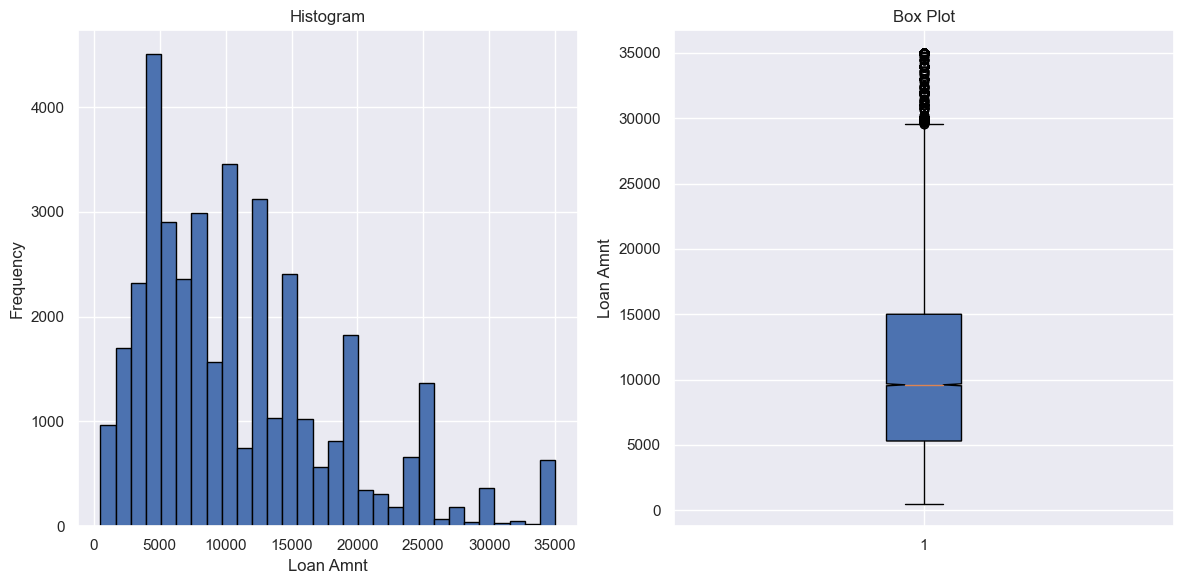

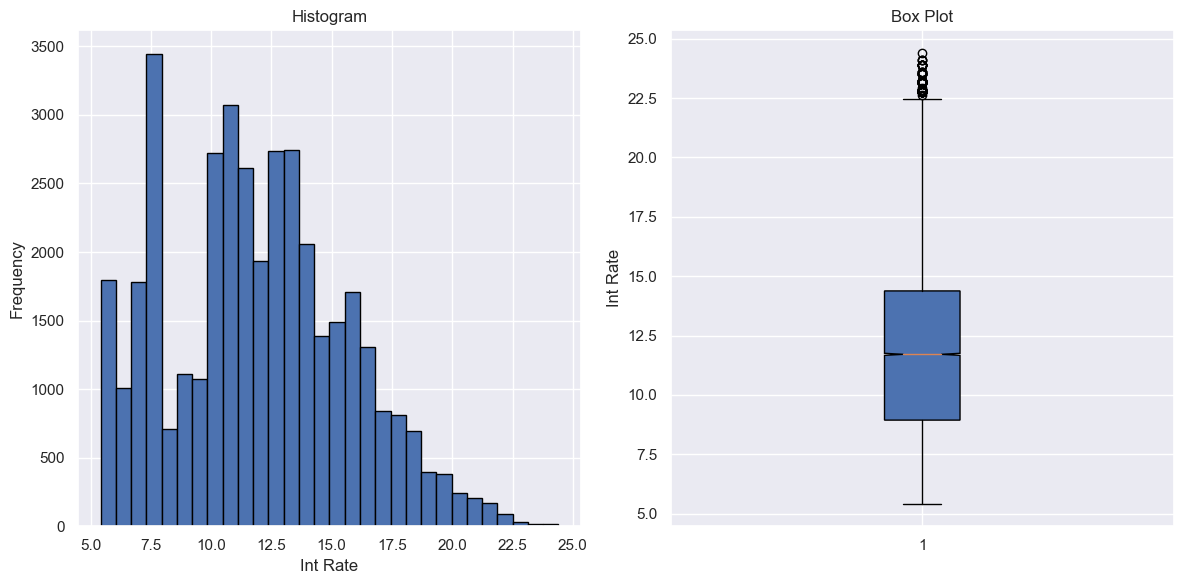

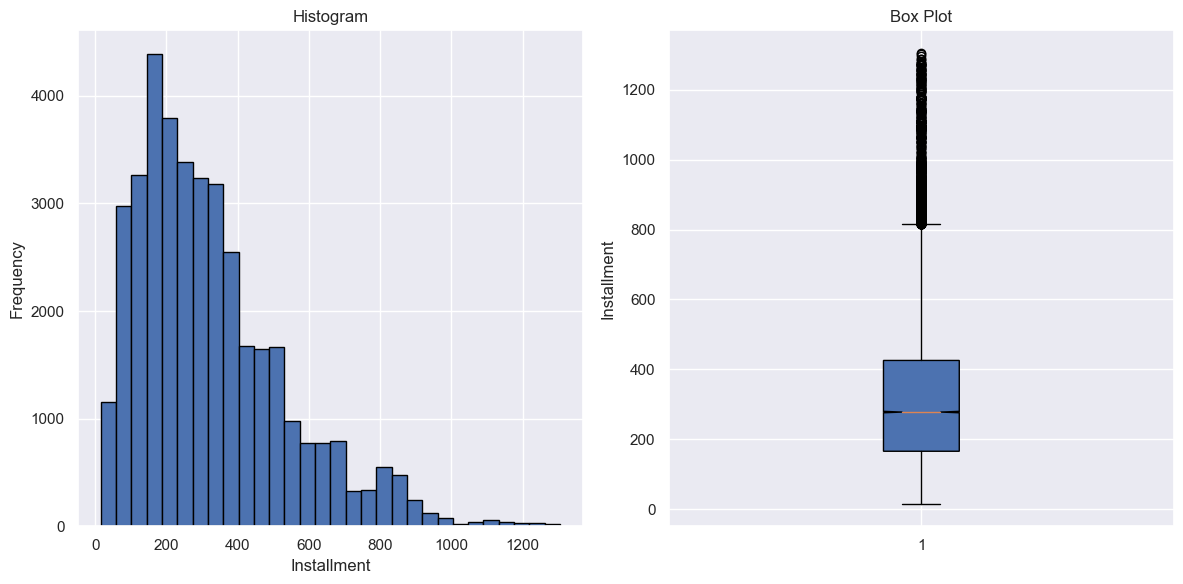

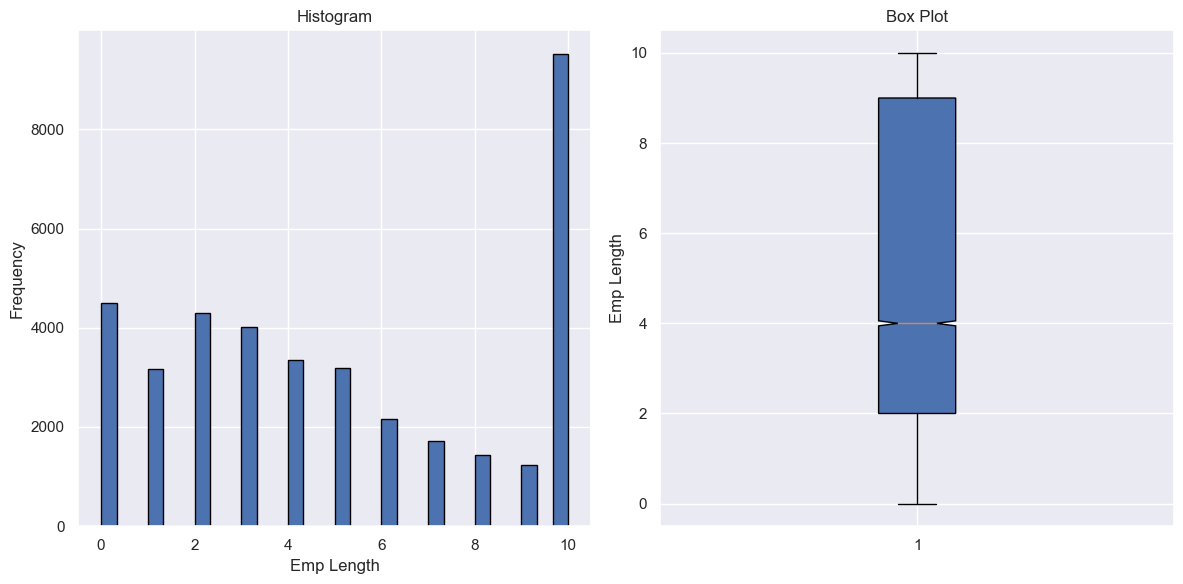

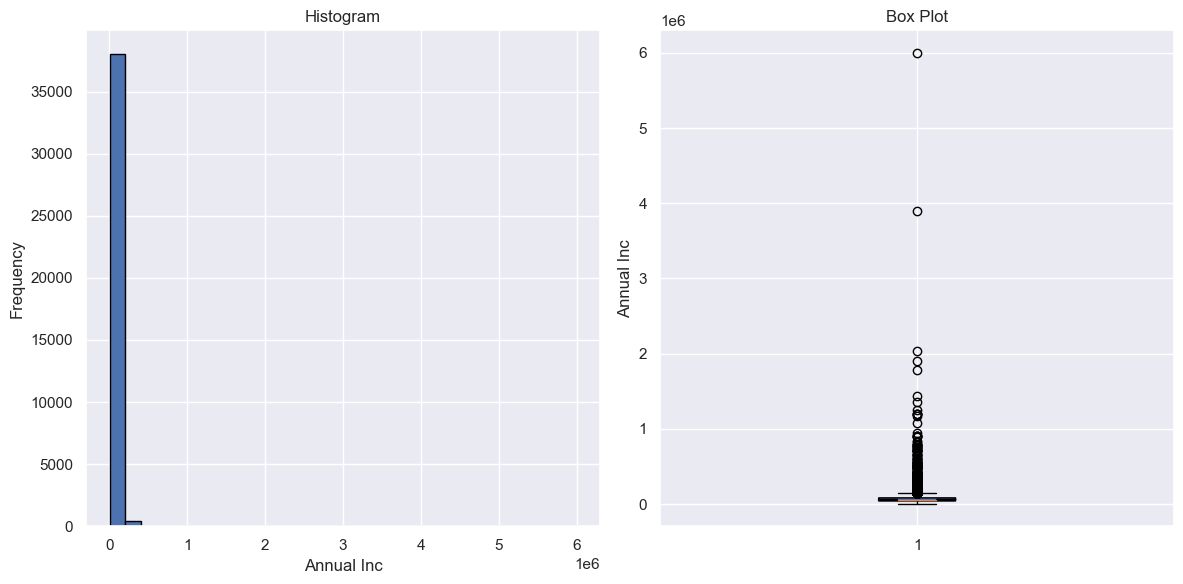

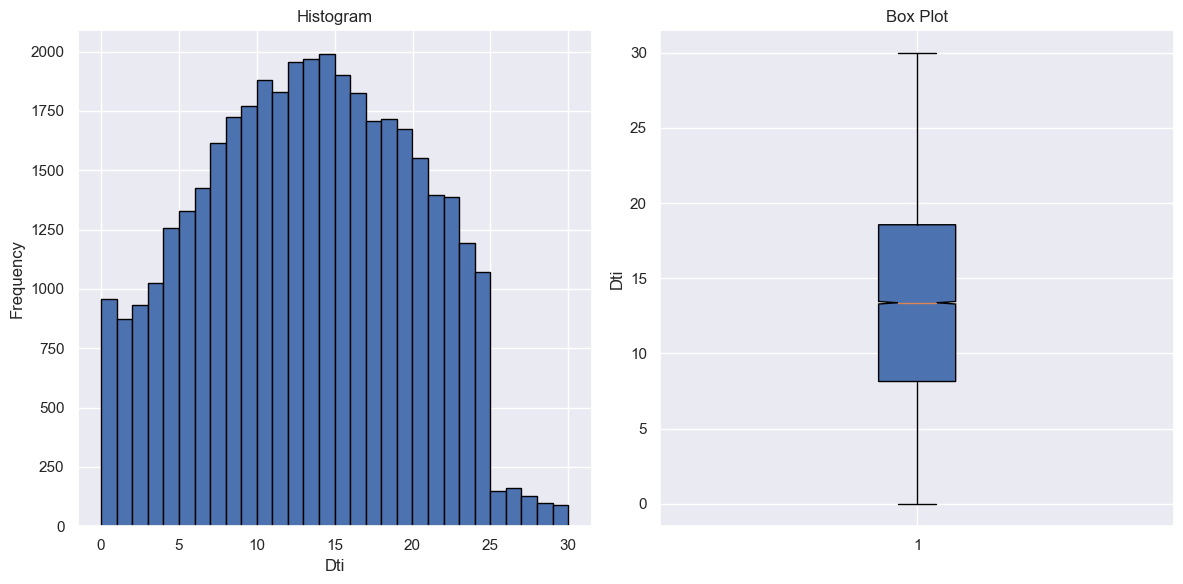

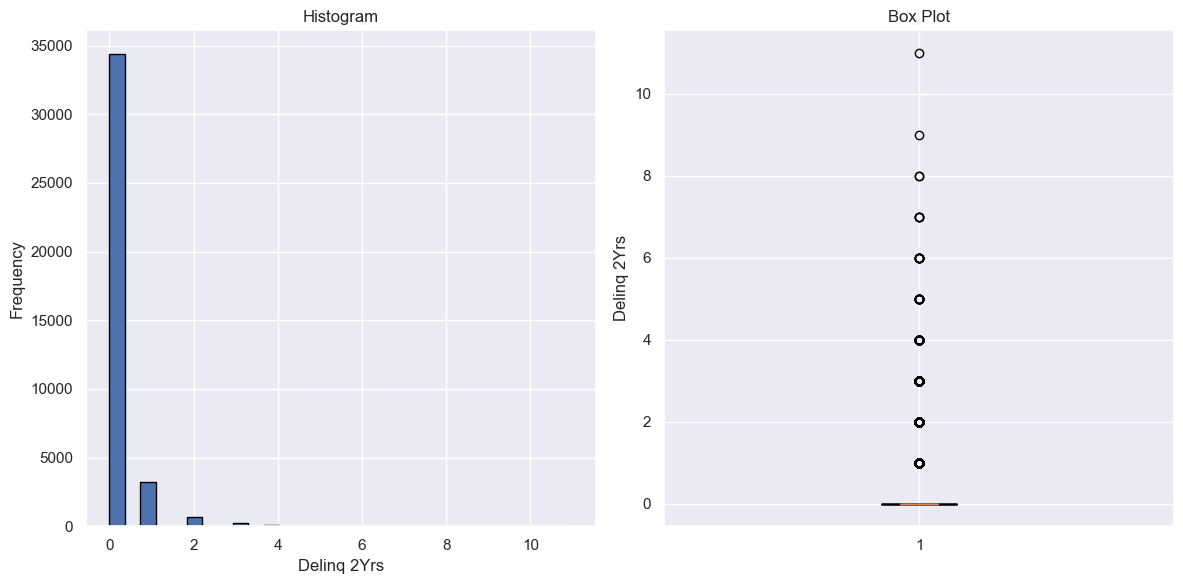

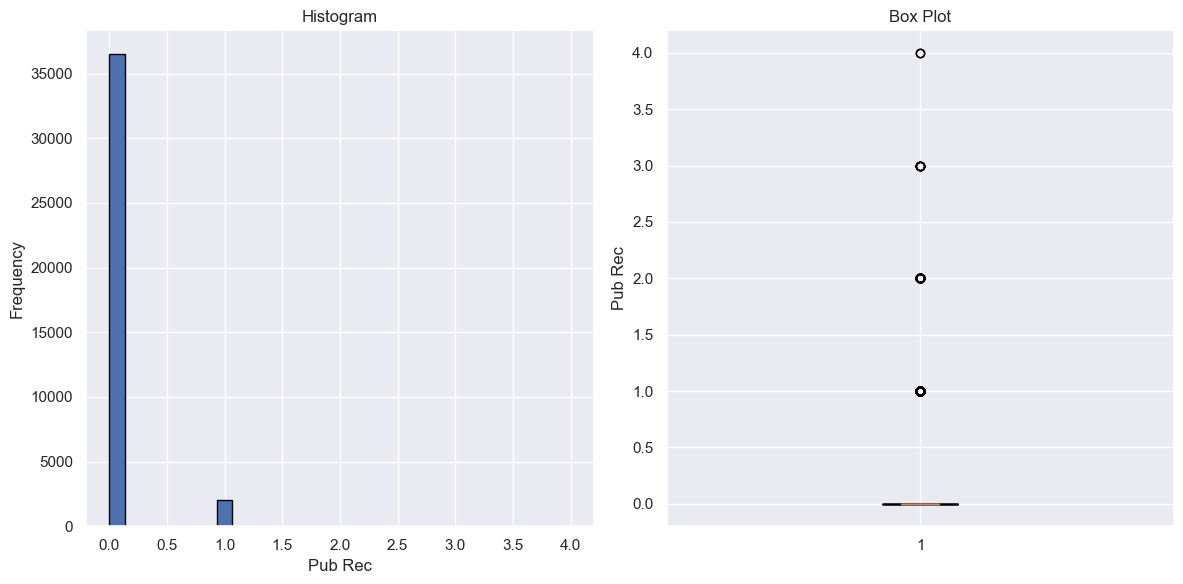

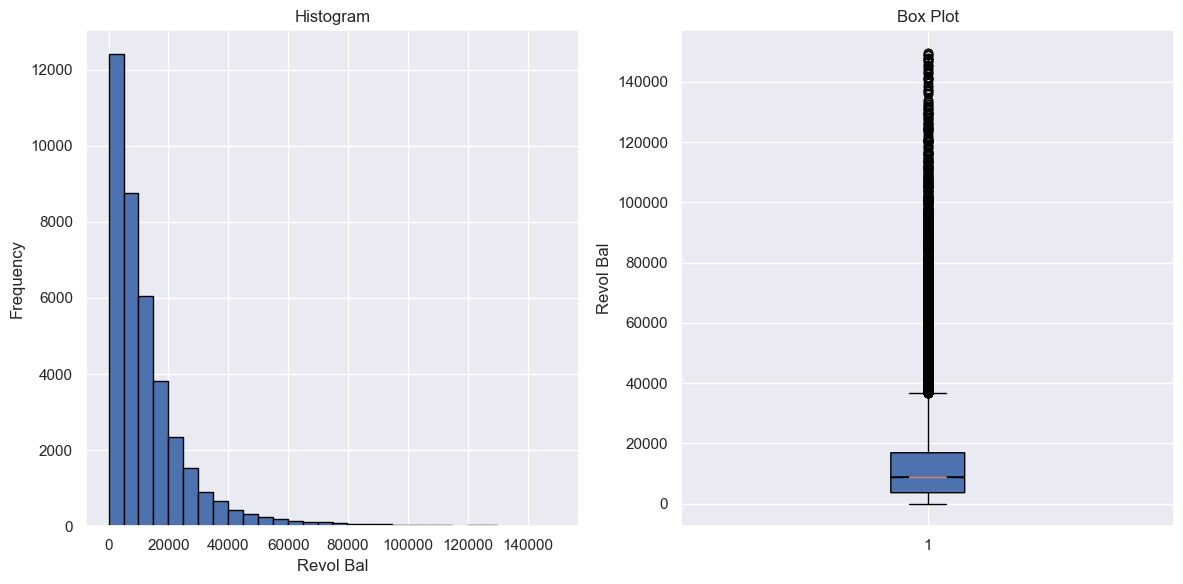

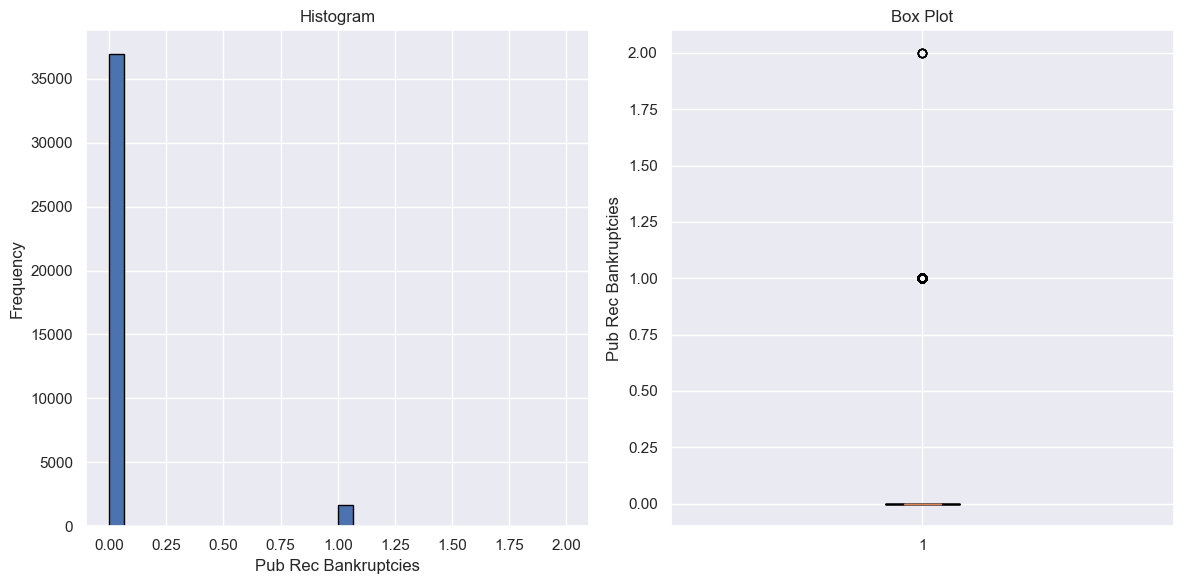

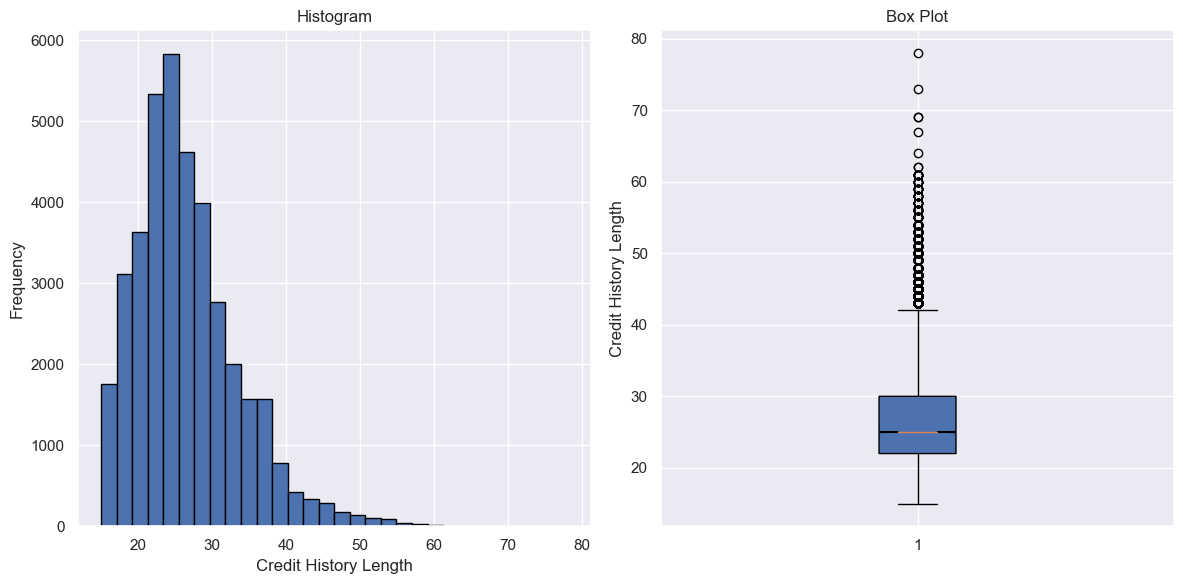

In [238]:
for col in num_cols:
    data = df[col]
    col_name = col.replace('_', ' ').title()
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plotting histogram
    axs[0].hist(data.sort_values(), bins=30, edgecolor='black')
    axs[0].set_title('Histogram')
    axs[0].set_xlabel(col_name)
    axs[0].set_ylabel('Frequency')
    axs[0].grid(True)

    # Plotting box plot
    axs[1].boxplot(data.sort_values(), patch_artist=True, notch=True)
    axs[1].set_title('Box Plot')
    axs[1].set_ylabel(col_name)
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


### Conclusions from Numerical Plots

- __loan_amnt__: Most of the people opted for loans took the loan amount in the range `$5000` to `$15000` where maximum people took loan amount of around `$5000`. The median amount is around `$10000`.
- __int_rate__: The interest for most of the loan is in the range of around `8.5%` to `14.5%` with a median interest of around `12%`.
- __installment__: Most of the installments are in the range `$180` to `$420` with median amount of around `$280`.
- __emp_length__: Most loan are taken by people having `10+ years` of experience followed by `newly joined employees`.
- __annual_inc__: There are clear outliers in annual income. The normal range is in `$4000` to `$150000`. The median income is around `$6000`.
- __dti__: Debt to income ratio is ranging from around `8` to `19`. The median is around `14`.
- __delinq_2yrs__: Most of the people has `0` delinquencies.
- __pub_rec__: Most of the people has 0 derogatory records.
- __revol_bal__: The range is around `$2000` to `$18000` with median around `$9000`.
- __pub_rec_bankruptcies__: Most people has `0` bankruptcy records.
- __credit_history_length__: The common range is `22` to `30 years`, with median of around `25 years`.

__Note__: All the above observations are without considering the current loan status.

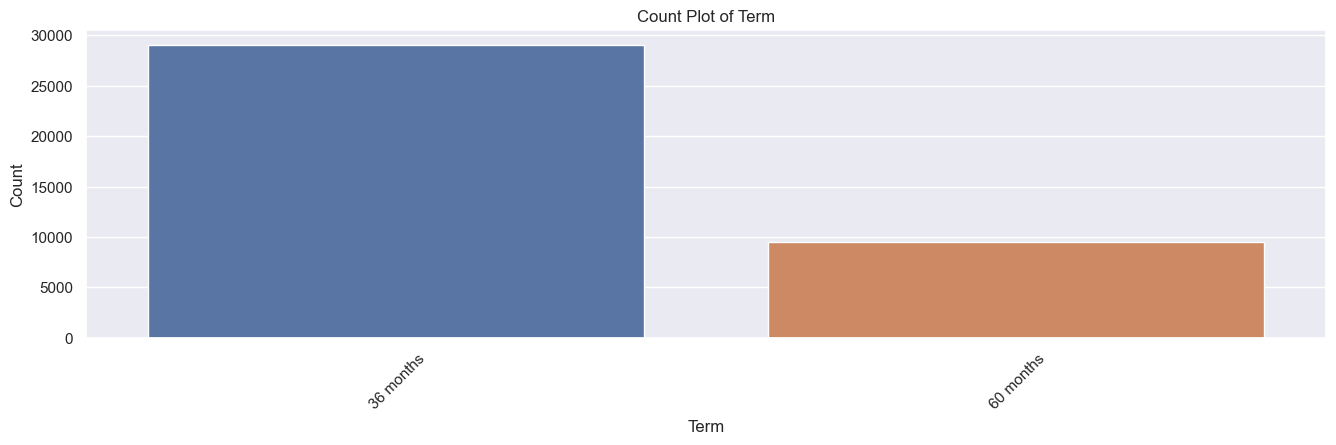

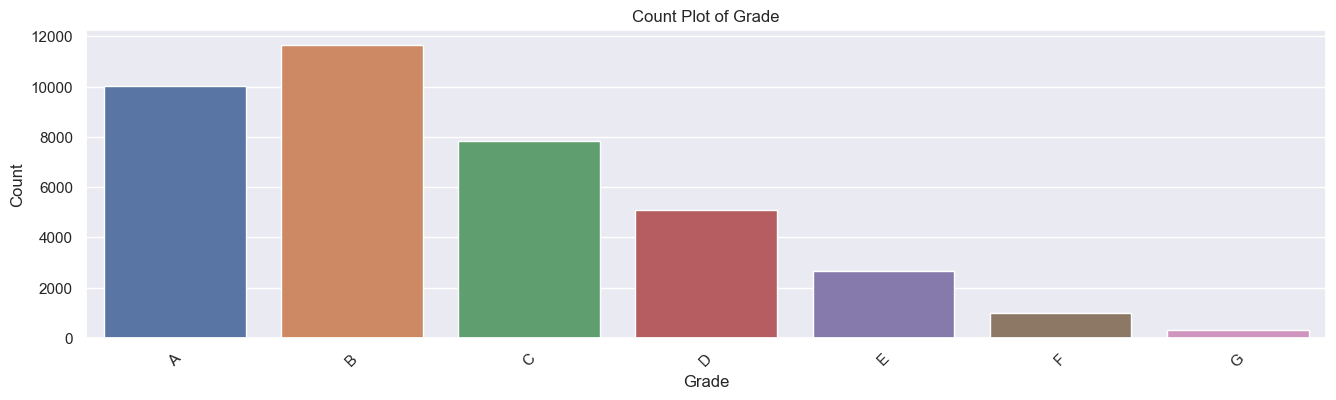

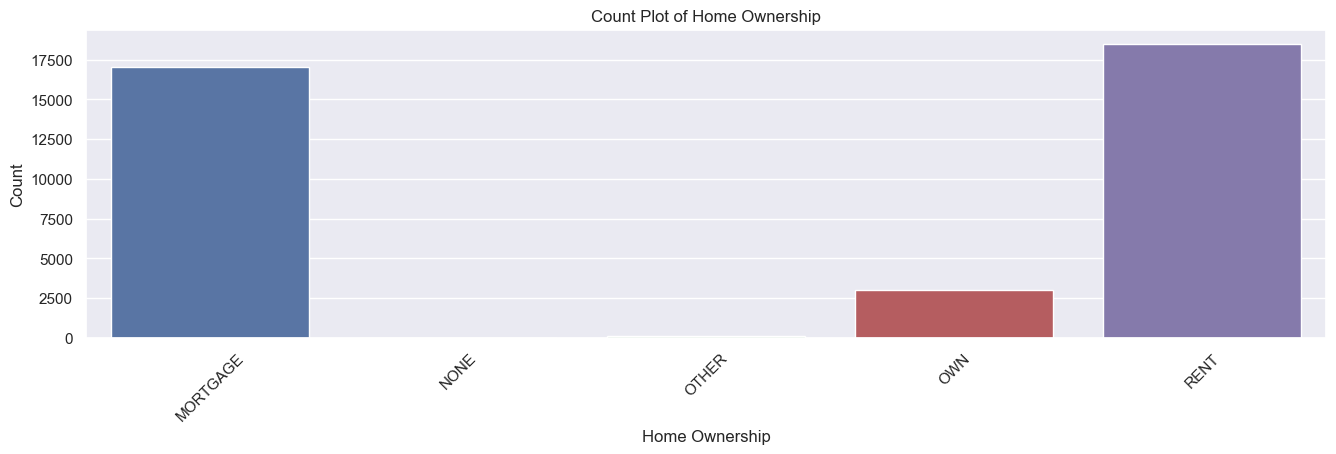

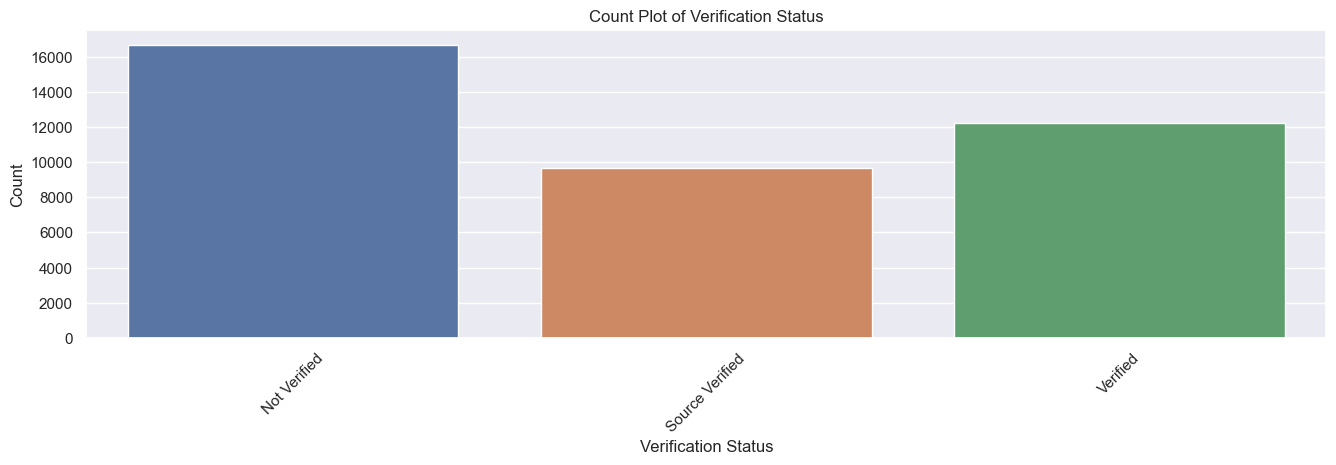

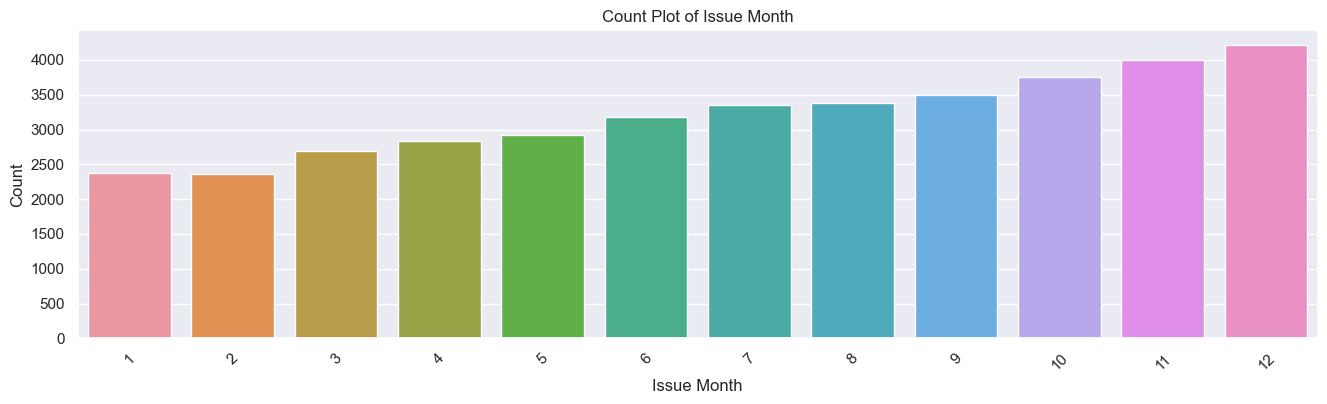

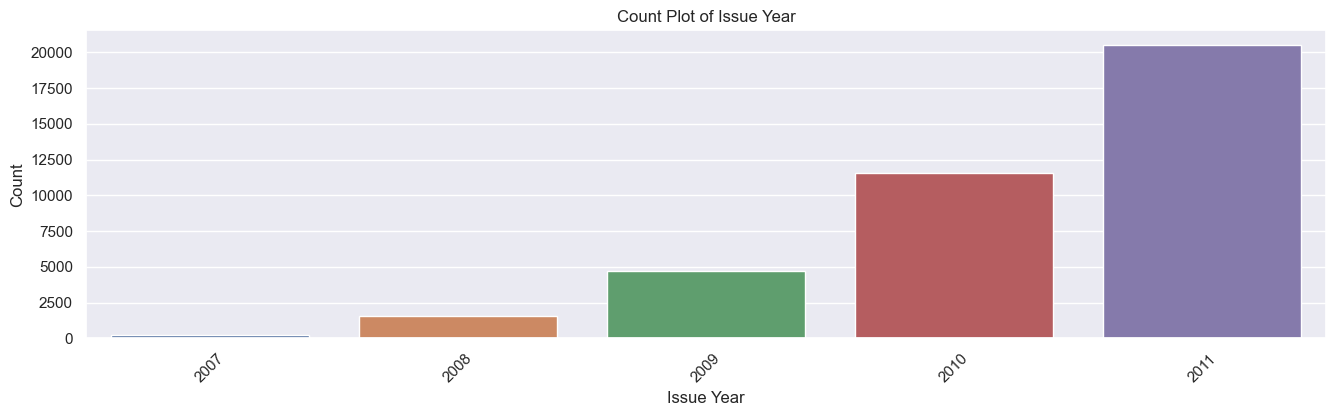

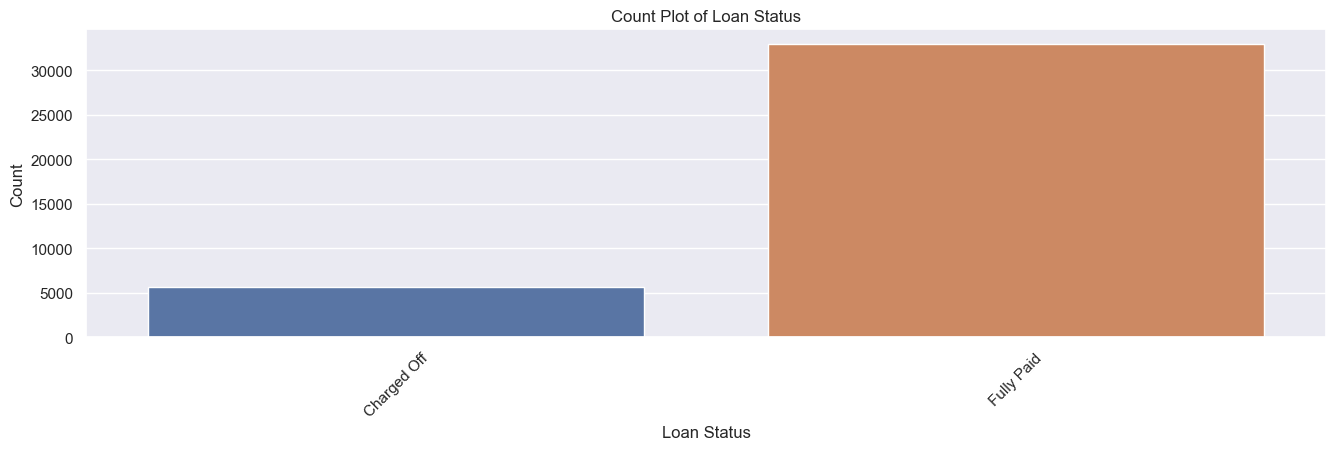

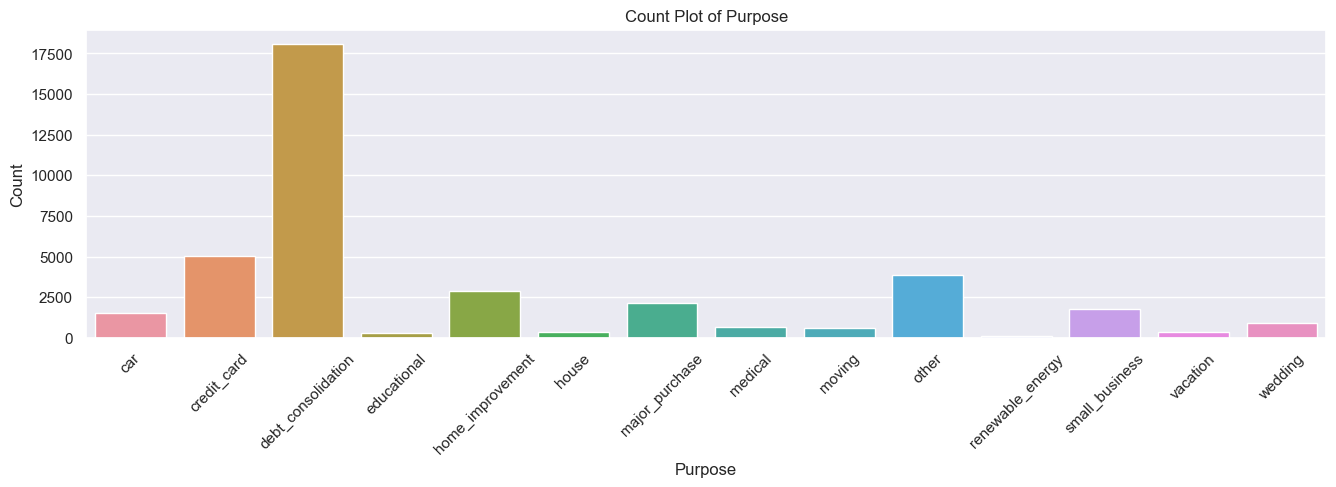

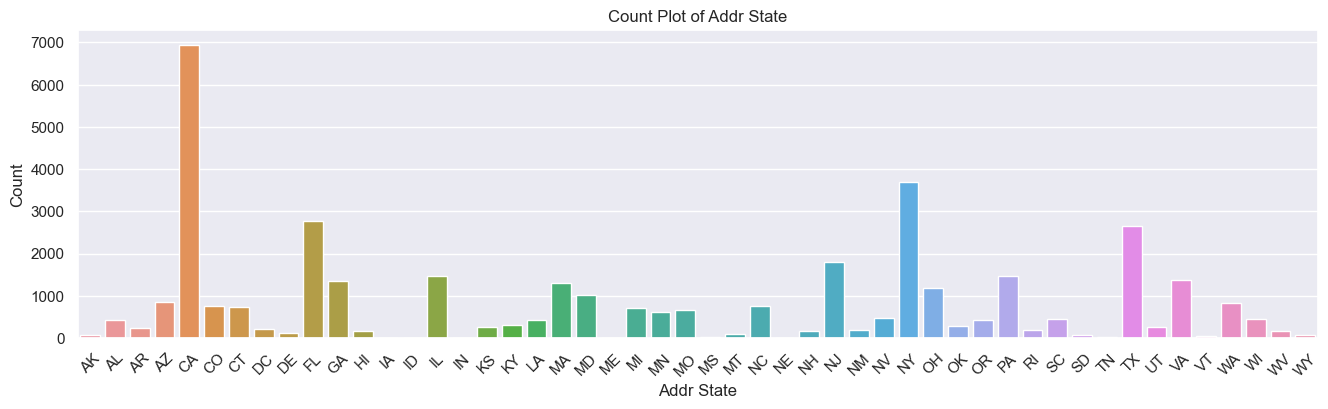

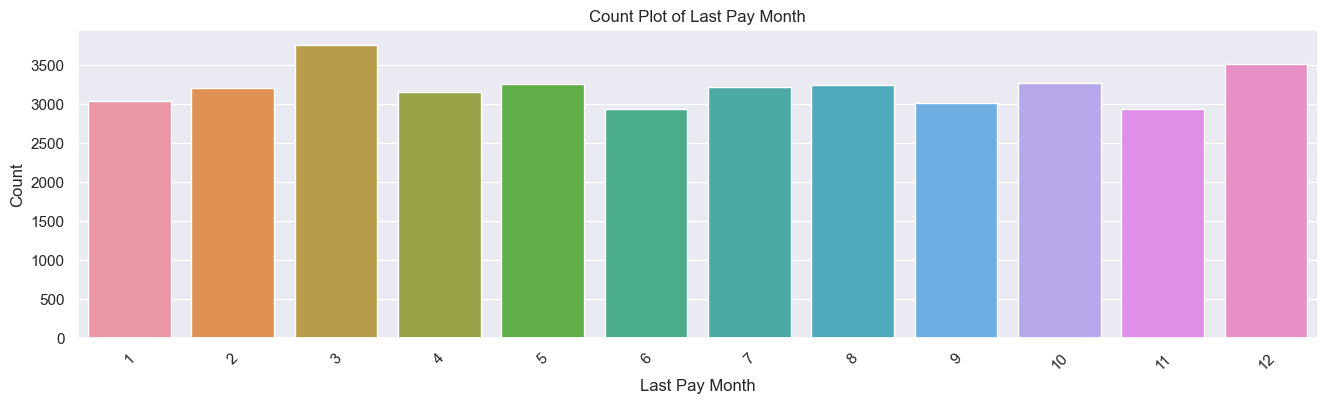

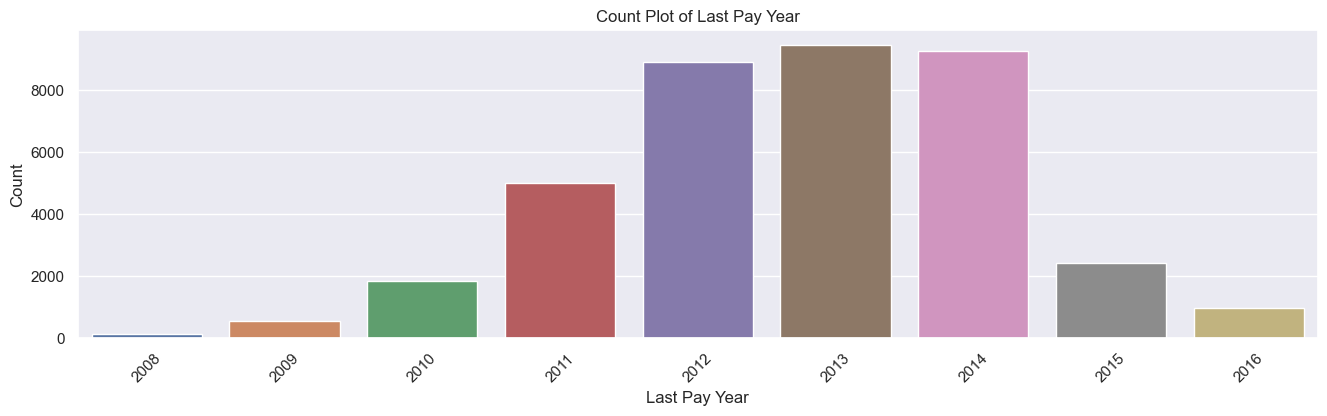

In [239]:
for col in cat_cols:
    col_name = col.replace('_', ' ').title()
    plt.figure(figsize=(16, 4))

    sns.countplot(x=df[col].sort_values())
    plt.xticks(rotation=45)

    plt.xlabel(col_name)
    plt.ylabel('Count')
    plt.title('Count Plot of '+col_name)
    plt.show()

### Conclusions from Categorical Plots
- __term__: There are two types of loans. One is of `3 years` and the other is `5 years` where most of the loans are `3 years` only.
- __Grade__: There are grades ranging from `A to G`, where most of the loan are given to `B grade` customers.
- __home_ownership__: Most of the loans are taken by people staying in `rented` houses followed by the ones having `mortgage` houses.
- __verification_status__: Majority of the loans are given to people `without verifying their income`.
- __issue_month__: The no. of loans issued has `increased gradually from January to December`.
- __issue_year__: The no. of loans issued has `increased exponentially from 2007 to 2011`.
- __loan_status__: Almost `15%` of the issued loans are Charged Off.
- __purpose__: Most of the people who took loans are for `Debt Consolidation` followed by `credit card bill repayment`.
- __addr_state__: Majority of the loans are taken by people from `California`. Next in the list is `New York` and then `Florida`.
- __last_pay_month__: Higher number of loans are paid in the month of `March` and lower number of loans are paid in `June`. We can clearly see that most people paid the loans in the end of financial year.
- __last_pay_year__: Most of the loans are paid lastly in the period `2012 to 2014`. Since the loans are issued from 2007 to 2011 and are of term 3years and 5 years, they are likely to be closed in the period 2012 to 2014.

__Note__: All the above observations are without considering the current loan status.

## Bivariate Analysis

### Numercial vs Loan Status

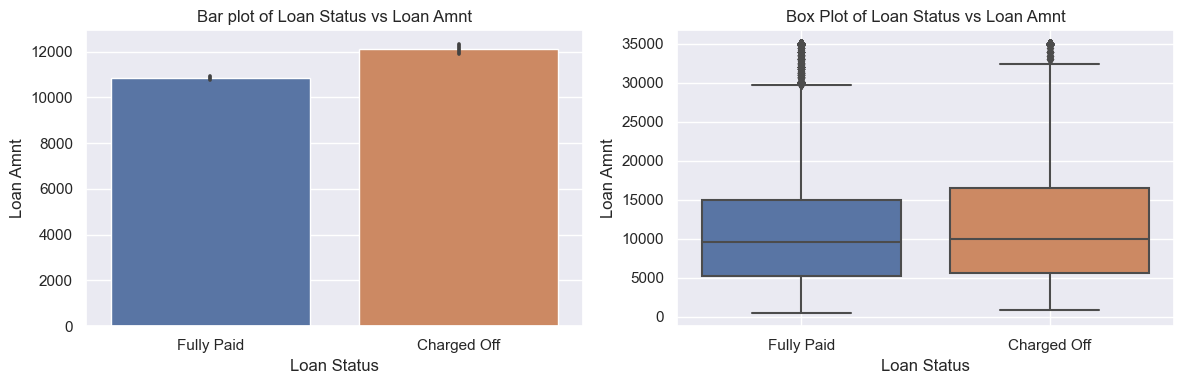

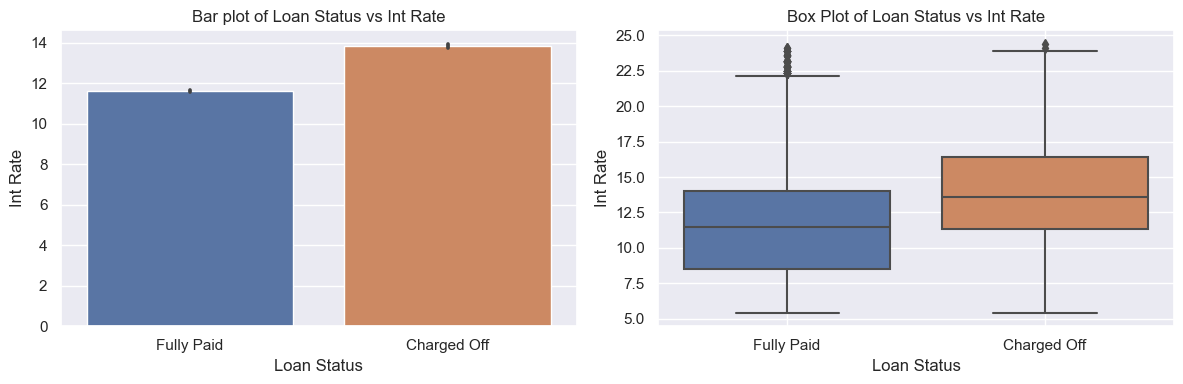

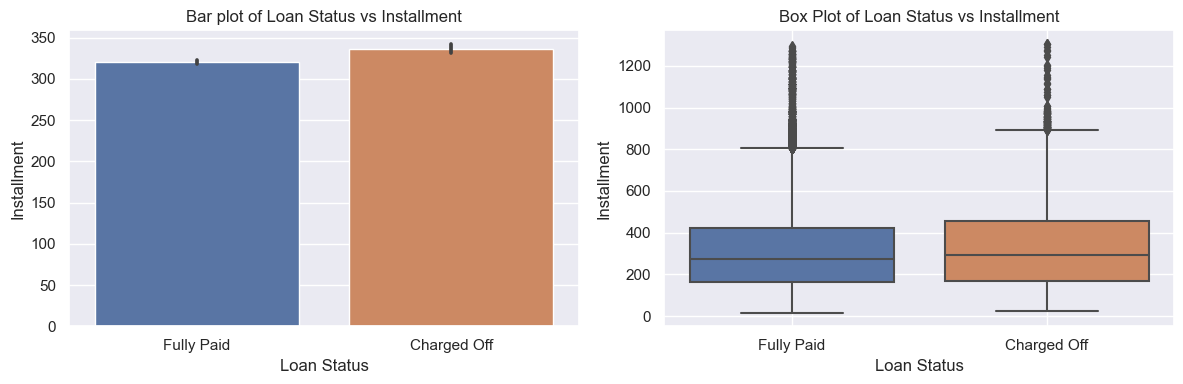

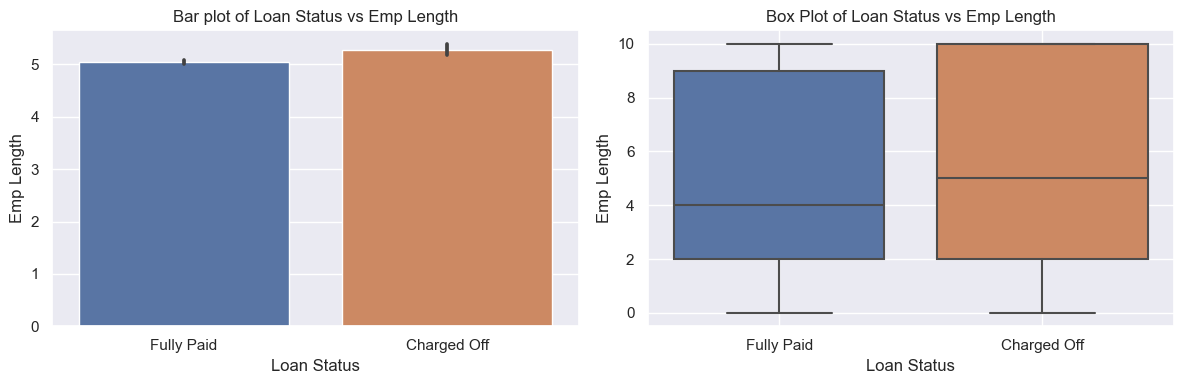

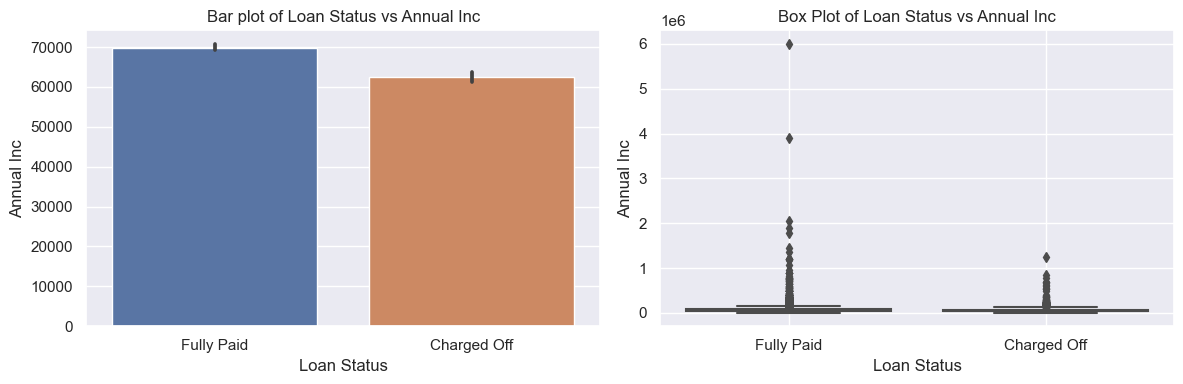

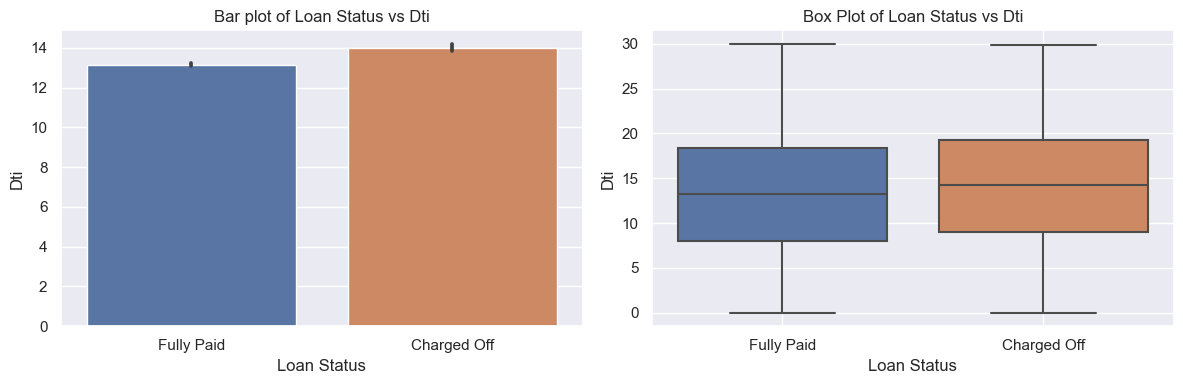

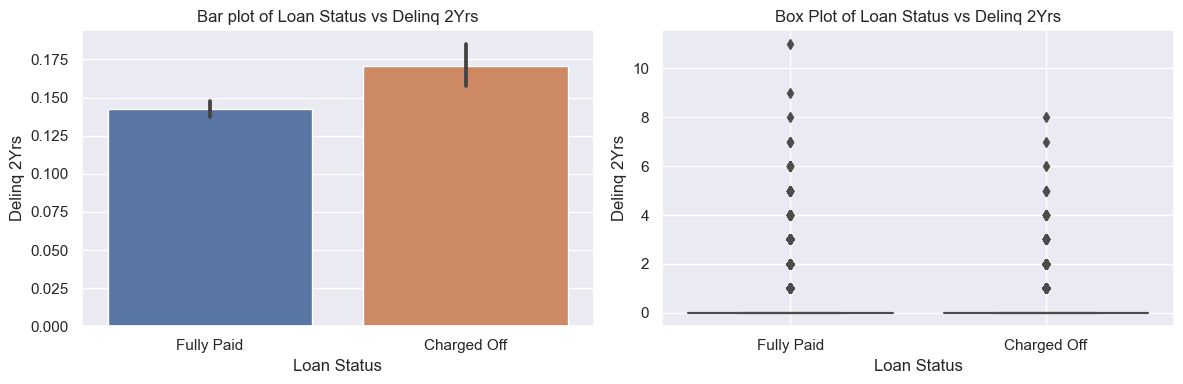

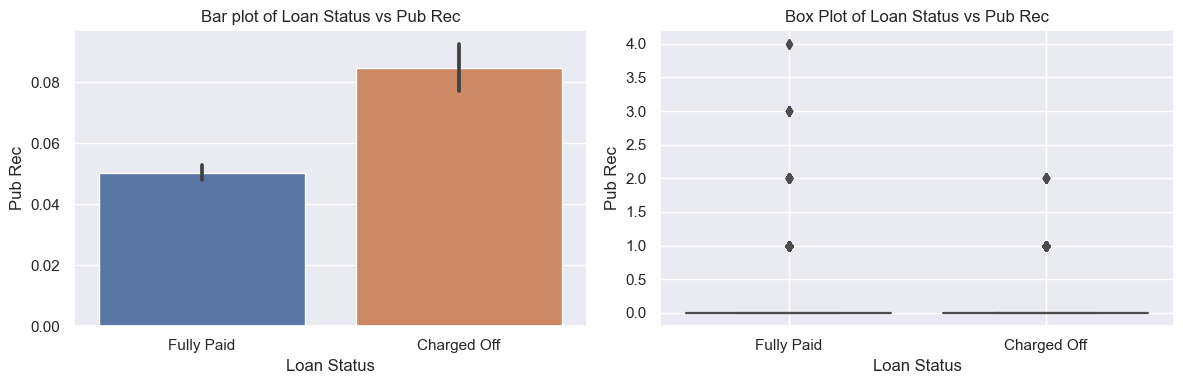

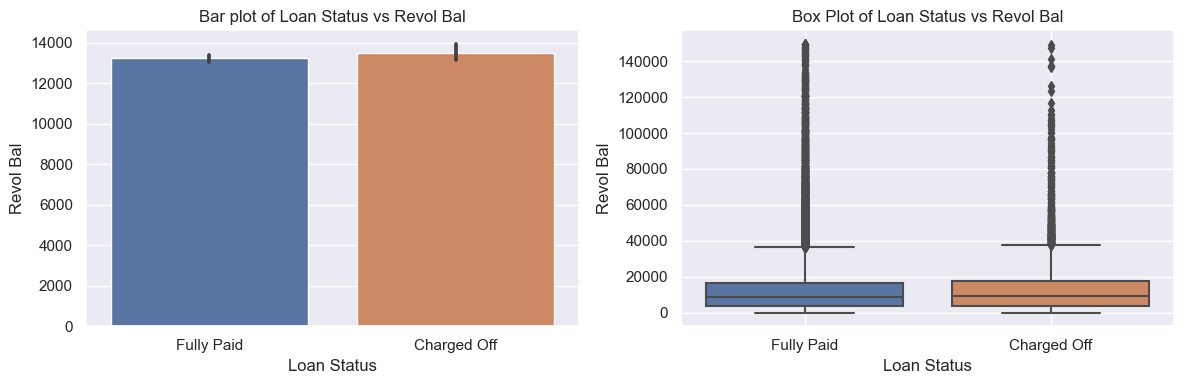

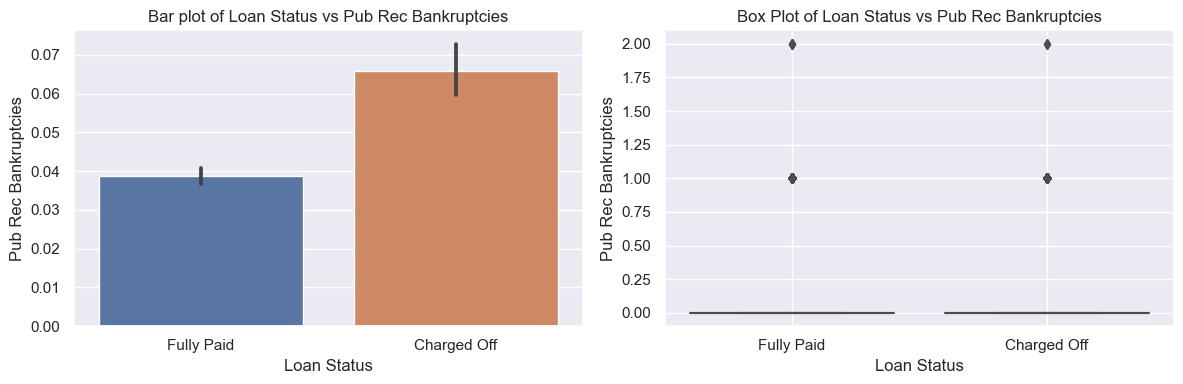

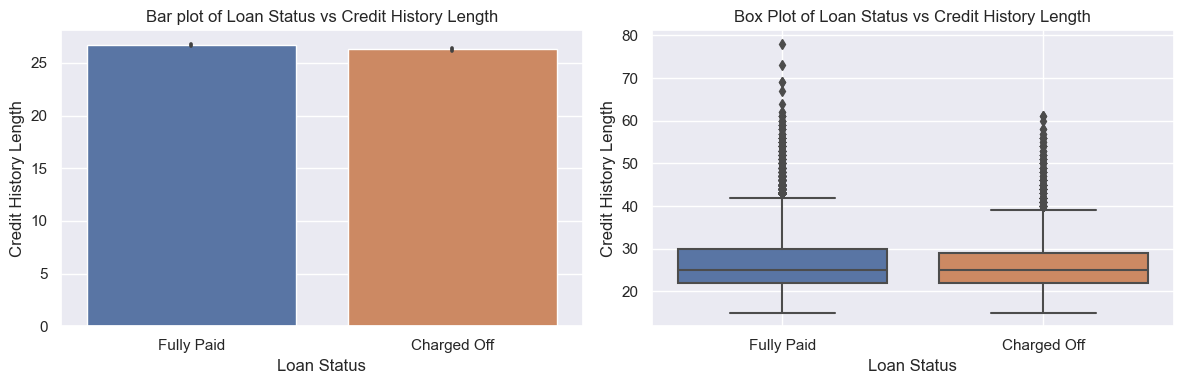

In [240]:
for col in num_cols:
    data = df[col]
    col_name = col.replace('_', ' ').title()
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    sns.barplot(x=df['loan_status'], y=df[col], estimator=np.mean, ax=axs[0])
    axs[0].set_title('Bar plot of Loan Status vs '+col_name)
    axs[0].set_xlabel('Loan Status')
    axs[0].set_ylabel(col_name)

    sns.boxplot(x=df['loan_status'], y=df[col], ax=axs[1])
    axs[1].set_title('Box Plot of Loan Status vs '+col_name)
    axs[1].set_xlabel('Loan Status')
    axs[1].set_ylabel(col_name)
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

### Conclusions from Numerical vs Categorical(Loan Status) Plots
- __loan_amnt__: The loan amount given to the people who charged off is little higher to those who fully paid. The median amount for `charged off` loans is `$10000` whereas for `fully paid` it is `$9600`.
- __int_rate__: The interest rates of fully paid loans are less compared to charged off loans. The median interest for fully paid is approx. `11.5%` and for charged off loans it is approx. `13.5%`.
- __installment__: Installments for both fully paid and charged off loans is usually in the range of `$180 to $420`.
- __emp_length__: The median employment length for fully paid is `4 years` and for charged off is `5 years`. Most of the loans are taken by people having employment length greater than `10 years` and charged off loans is also higher in 10+ years employment length.
- __annual_inc__: The annual income of people who paid fully is having a median of `$60000` and for people who charged off is having a median of `$53000`. The annual income of people who charged off has no very big difference with people who fully paid.
- __dti__: The Debt to Income ratio of charged off people is little higher compared to people who fully paid. It's median is around `13` for fully paid and around `14` for charged off.
- __delinq_2yrs__: It is little higher for people who charged off compared to people who fully paid. The median is same for both.
- __pub_rec__: This pattern is also similar to delinq_2yrs.The median is 0 for both.
- __revol_bal__: The range is similar for both. The median for fully paid is slightly less than charged off people.
- __pub_rec_bankruptcies__: The median is 0 for both.
- __credit_history_lenght__: It is same for both fully paid and charged off.

### Categorical vs Loan Status

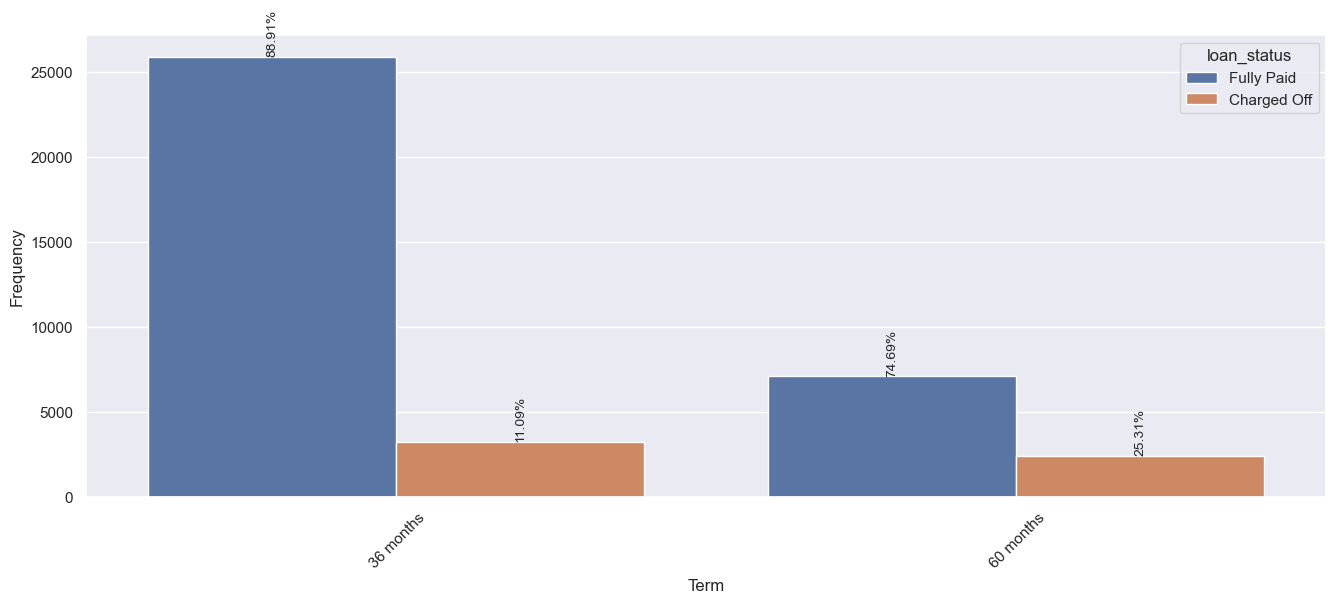

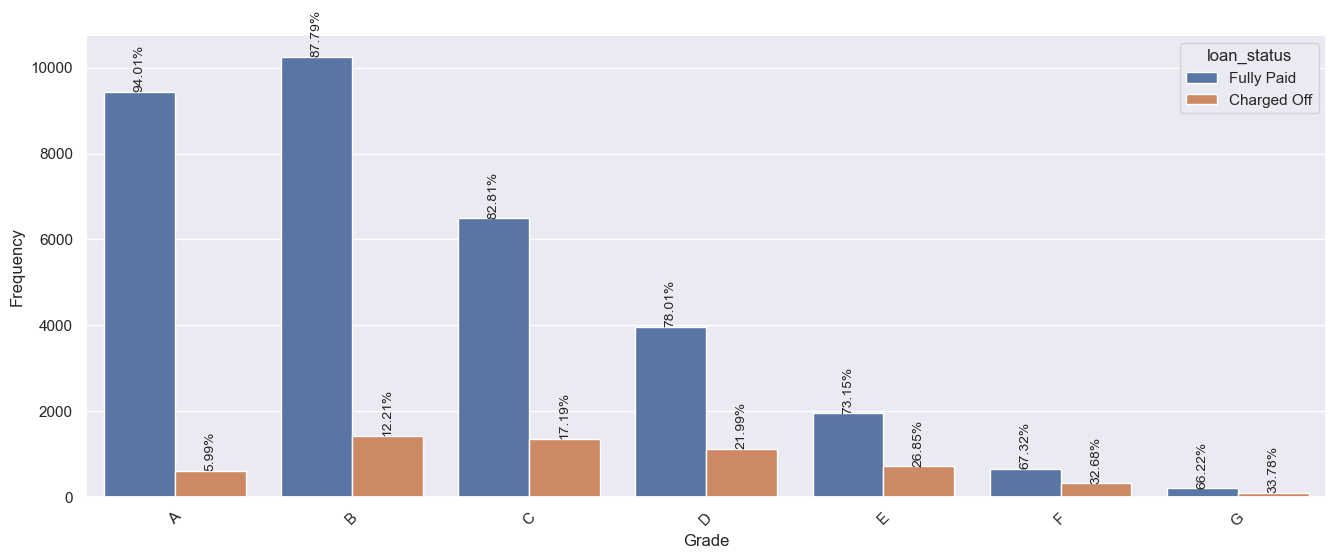

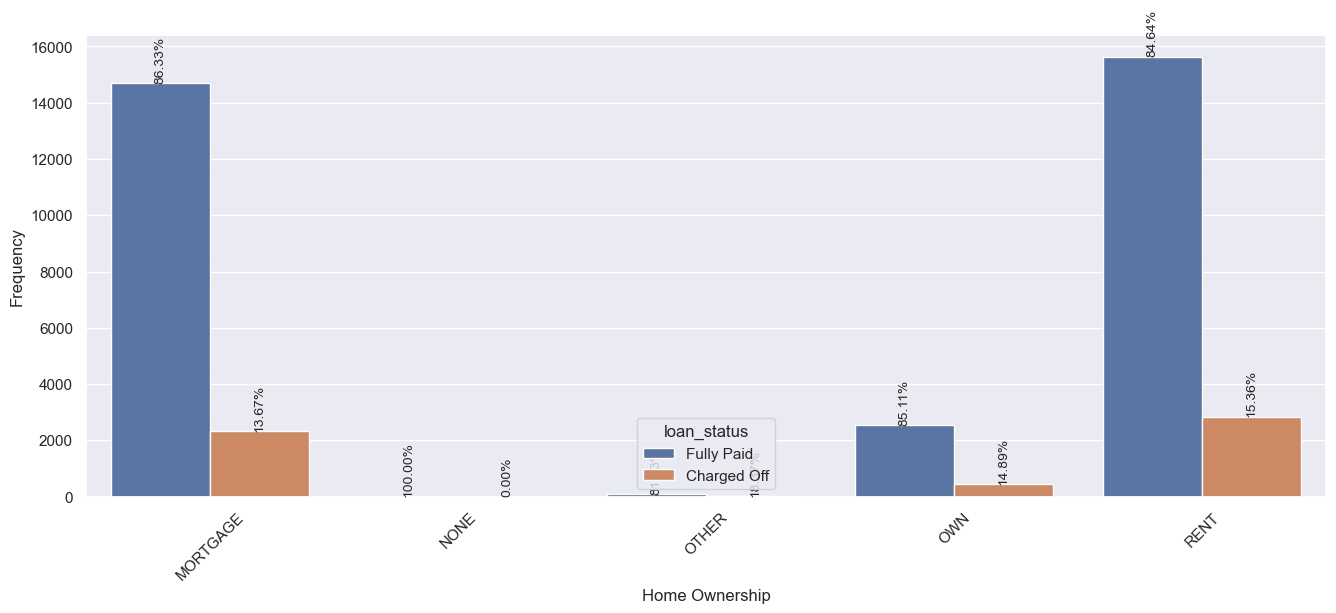

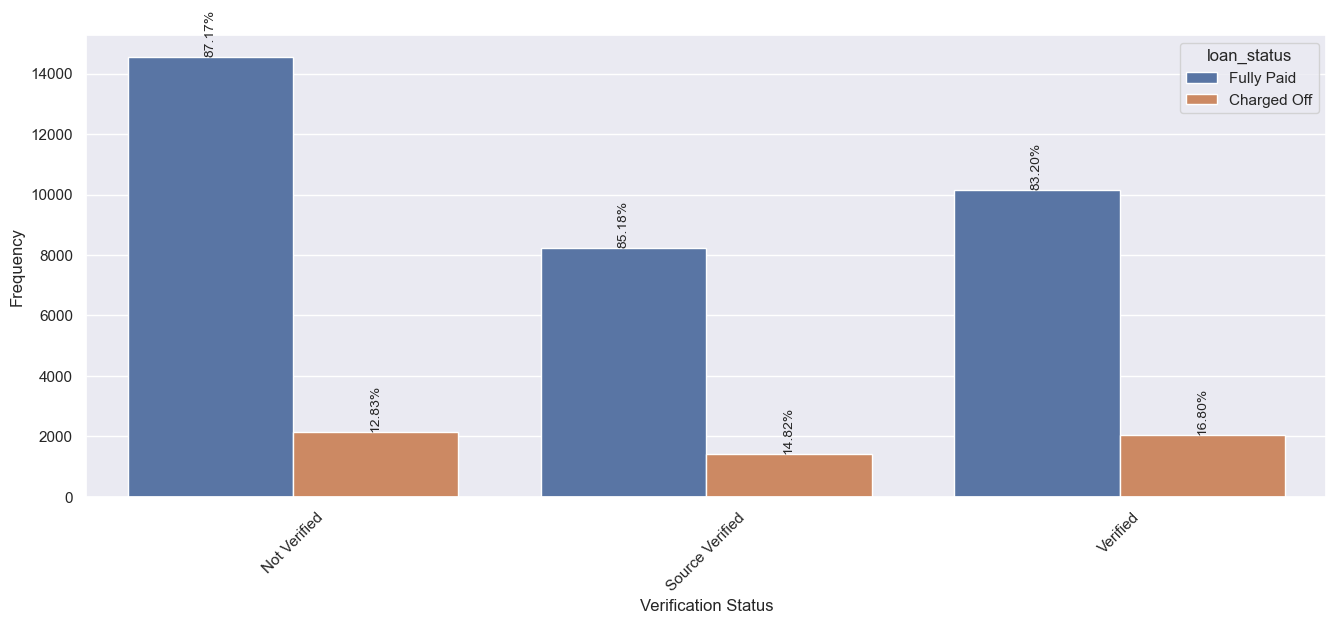

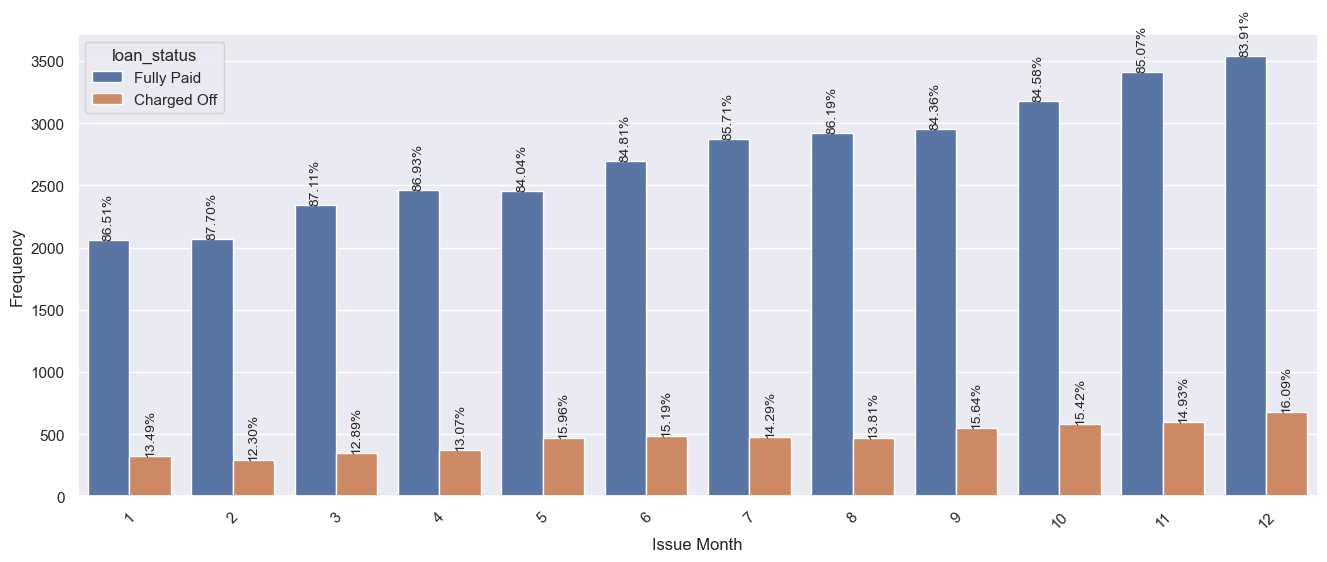

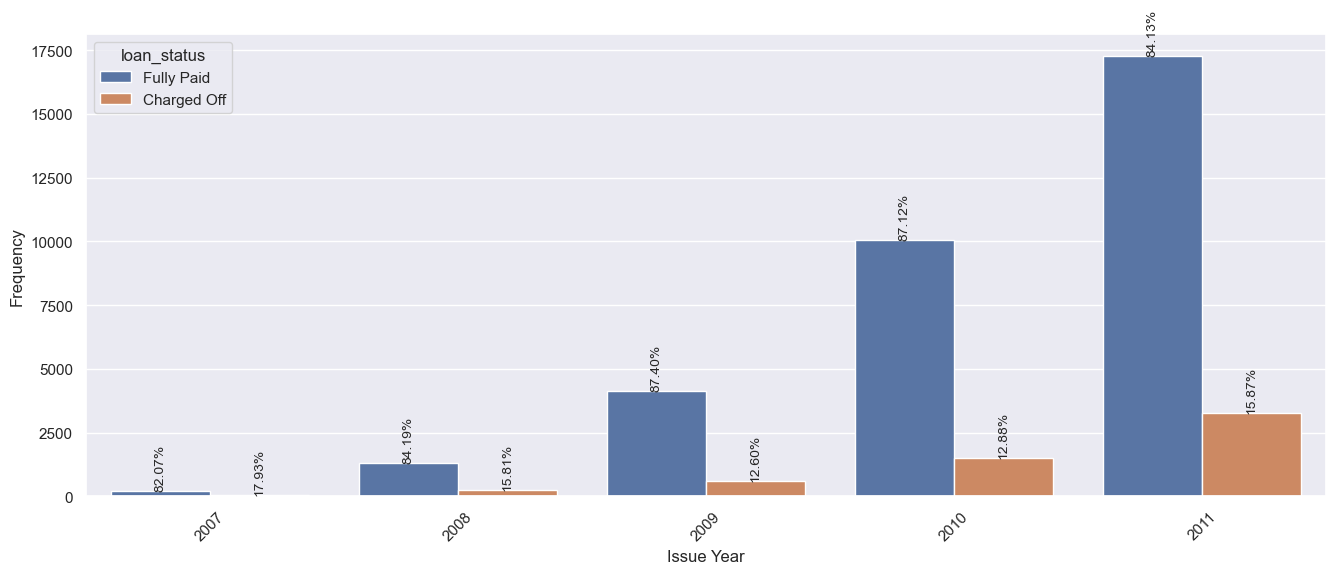

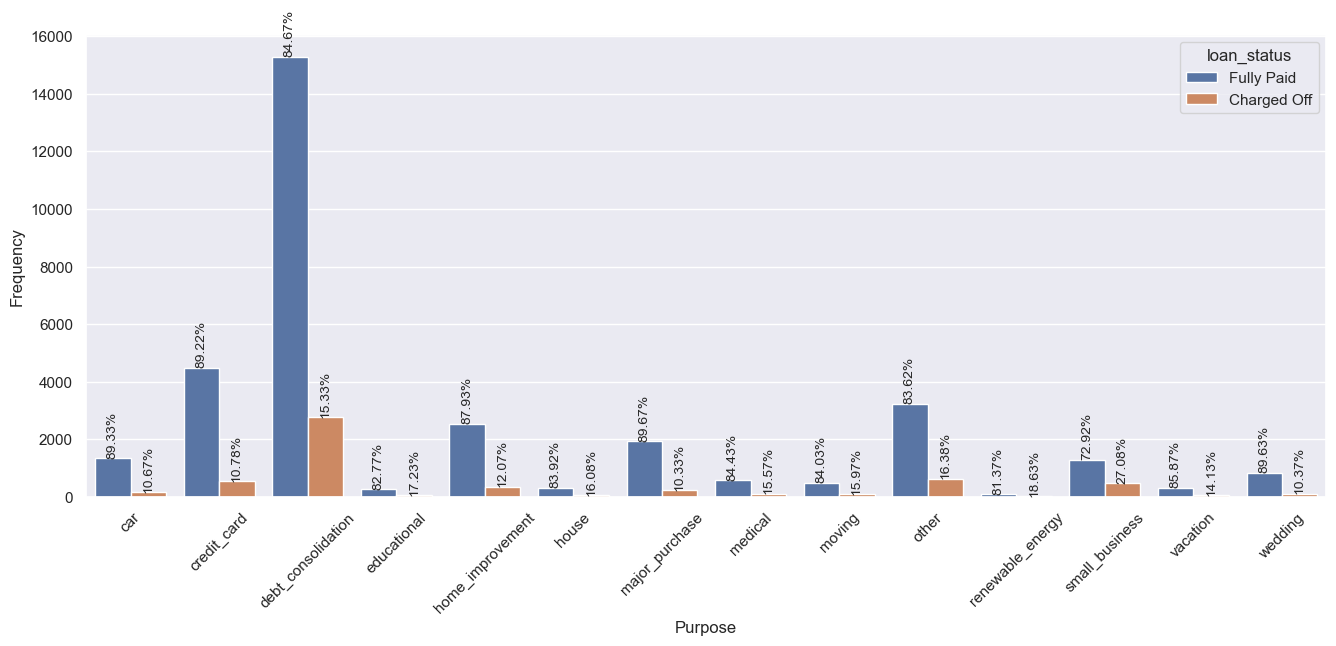

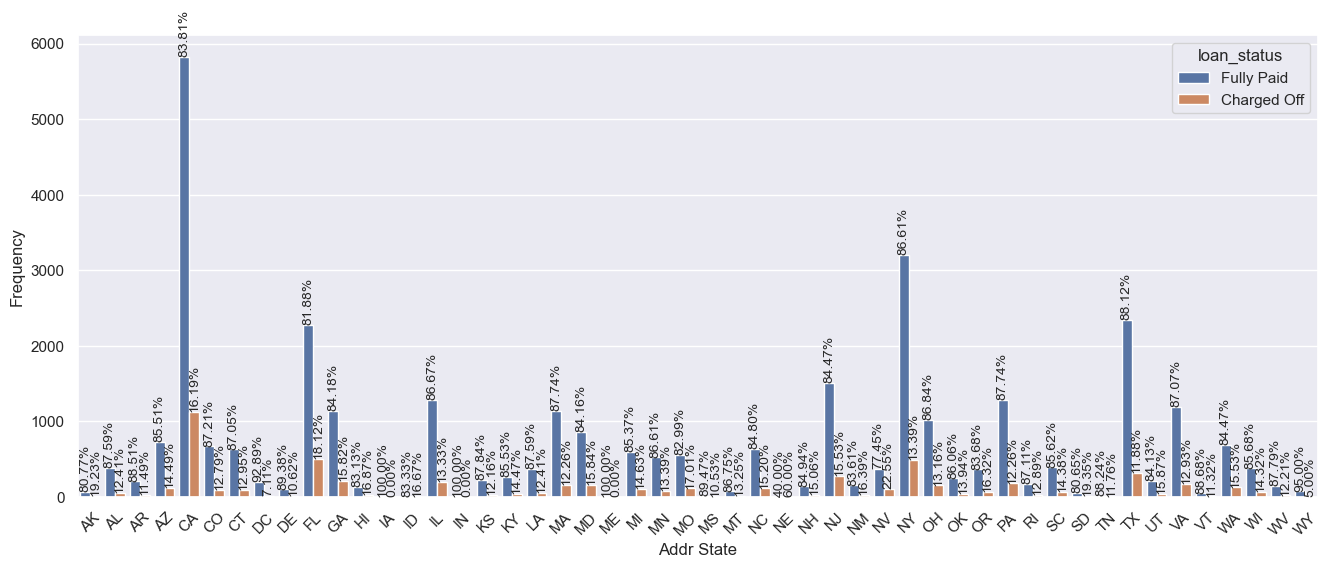

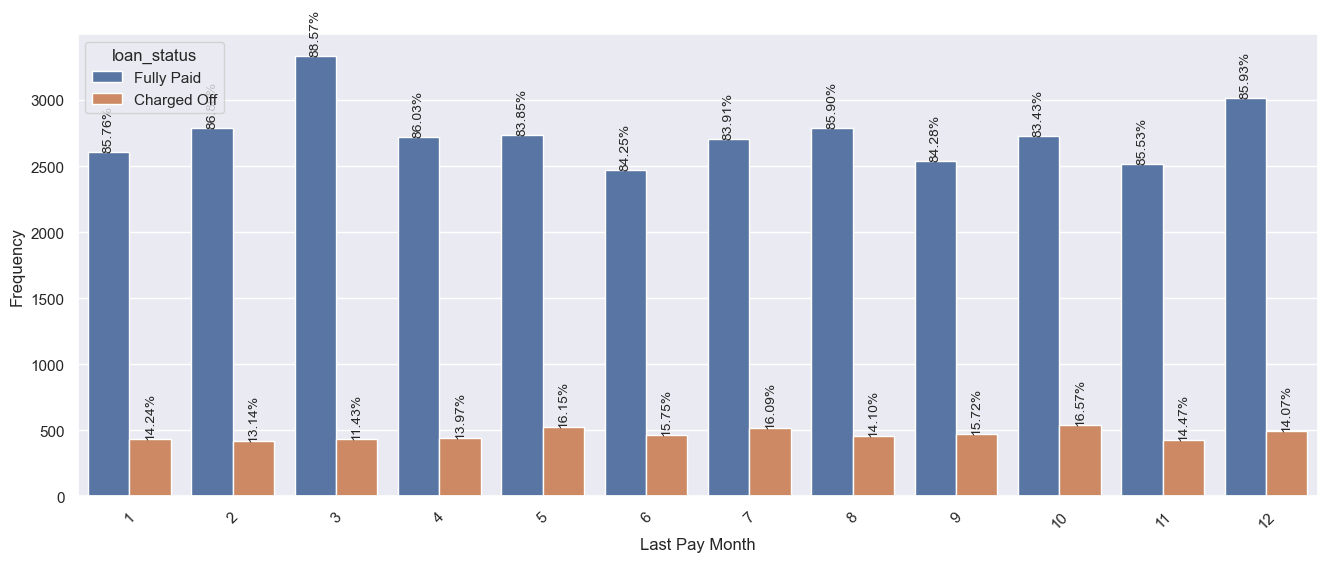

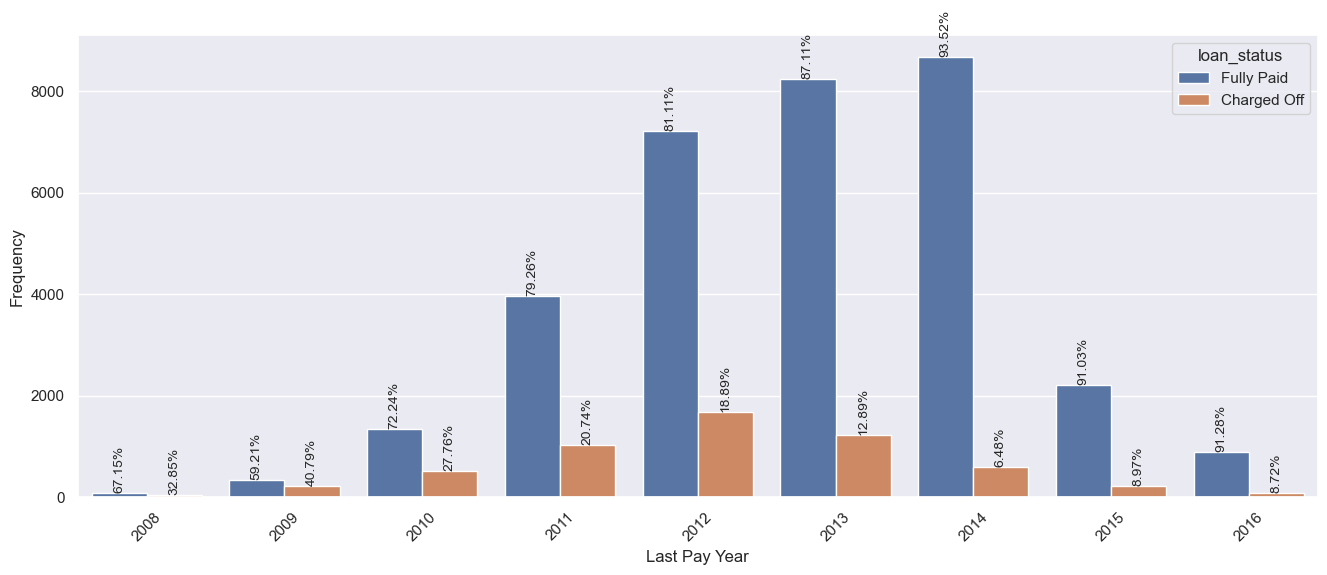

In [295]:
for col in cat_cols:
    if col == 'loan_status':
        continue
    col_name = col.replace('_', ' ').title()
    plt.figure(figsize=(16, 6))
    plt.xticks(rotation=45)
    ax = sns.countplot(x=df[col].sort_values(),hue=df['loan_status'])

    size = len(ax.patches)//2    
    heights = [p.get_height() for p in ax.patches]
    
    for index, p in enumerate(ax.patches):
        if (index < size):
            height = p.get_height()
            total = heights[index] + heights[index+size]
            ax.text(p.get_x() + p.get_width()/2.,
                    height,
                    '{:.2f}%'.format((height/total) * 100),
                    ha="center", va="bottom", rotation=90, fontsize=10)
        else:
            height = p.get_height()
            total = heights[index-size] + heights[index]
            ax.text(p.get_x() + p.get_width()/2.,
                    height,
                    '{:.2f}%'.format((height/total) * 100),
                    ha="center", va="bottom", rotation=90, fontsize=10)
        
    plt.xlabel(col_name)
    plt.ylabel('Frequency')
    plt.show()

### Conclusions from Categorical vs Categorical(Loan Status) Plots
- __term__: 3 year loans are more than 5 year loans. Charged Off loans are more in 5 year loan compared to 3 year loans.
- __grade__: Charged Off loans are comparatively `less in A and B grade` customers and `more in G grade` which is almost `34%`.
- __home_ownership__: Charged Off loan percentage is `more in RENT` category followed by `MORTGAGE`.
- __verification_status__: Most of the loans are given without verifying the income. But the percentage of charged off is surprisingly less for the not verified category. For income verified loans, the charged off percentage is `16.8%` which is highest.
- __issue_month__: The no. of loans given is gradually increasing from January to December. The `charged off` percentage is `higher` to the loans given in `December`.
- __issue_year__: The no. of loans given in 2011 are very high and so the charged off percentage.
- __purpose__: Most of the loans are taken for debt consolidation. But the percentage of charged off is `highest in small business` which is `27%` followed by `renewable energy` and `educational loans`
- __addr_state__: Though `California`(CA) people took more loans, `60%` of loans given to `Nebraska`(NE) people are charged off. `22.5%` of loans given to `Nevada`(NV) people are charged off.
- __last_pay_month__: The loans for which the last payments are made are `more` in the month of `October` and `less` in `March`
- __last_pay_year__: The loans for which the last payments are made in `2009` are mostly `charged off` with percentage of `40.7%`. Whereas the loans lastly paid in `2014` are `least charged off`.

### Multivariate Analysis

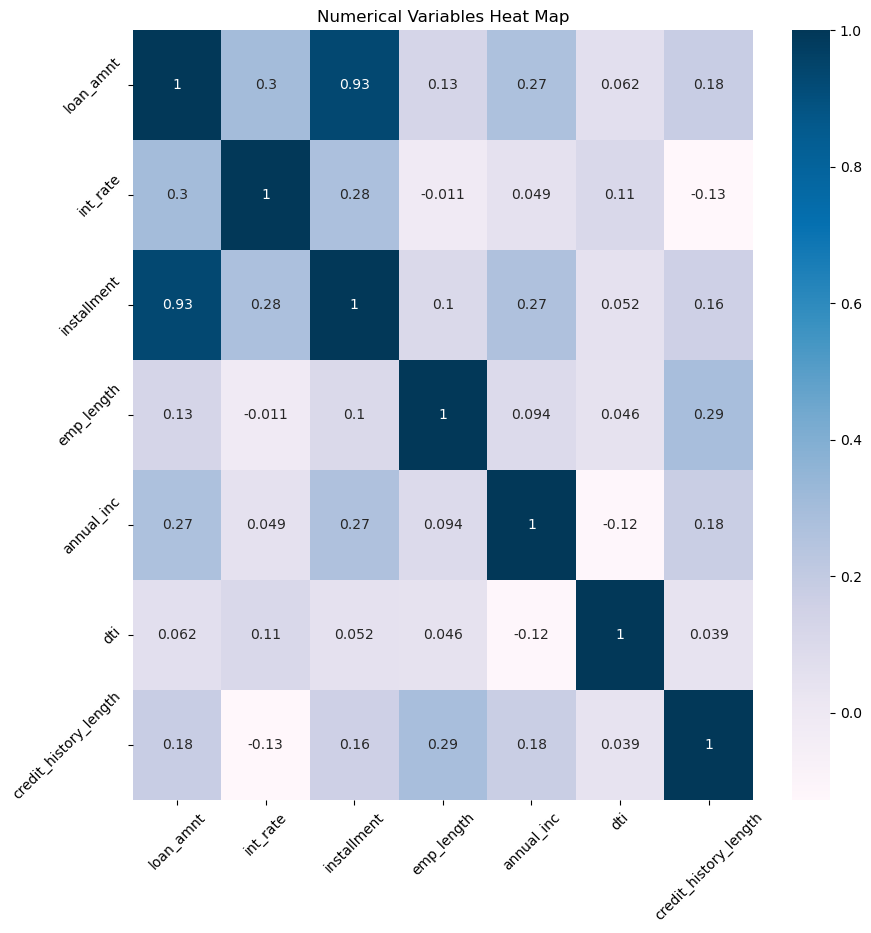

In [72]:
plt.figure(figsize=(10, 10))
sns.heatmap(df[['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti', 'credit_history_length']].corr(), cmap='PuBu', annot=True)

plt.title("Numerical Variables Heat Map")
plt.yticks(rotation=45)
plt.xticks(rotation=45)

plt.show()

### Conclusions from heat map
- Loan amount and installment are having more correlation.
- Loan amount and interest rate is having some correlation since if the loan amount is more, interest is likely to be more.
- Loan amount is having some correlation with employment length since most of the loans are taken by employees having experience more than 10 years.
- Loan amount is having some correlation with annual income since people who have more income can get more loan amount.
- Loan amount have least correlation with debt to income ratio(dti).
- Loan amount have little correlation with credit history length. 
- Interest rate and installment are having some correlation since if interest rate is more, installment becomes more.
- Interest rate and emp length are negatively correlated. May be people of more experience pay better and get loans for lesser interest.
- Interest rate and annual income are least correlated.
- Interest rate and debt to income ratio(dti) are somehow correlated. People have high dti will get loans with more interest rate.
- Interest rate and credit history length are negatively correlated, since those having high and better credit history get loans for lesser interest.
- Installment and employment lenght are little correlated. People with more experience tend to pay more installments.
- Installment is correlated to annual income usally because people who have more annual income can pay more installments.
- Installment is least correlated with debt to income ratio(dti).
- Installment is little correlated with credit history length.
- Employment length is little correlated with annual income and dti.
- Employment length is more correlated with credit history length since they might have been maintaining credit line.
- Annual income and debt to income ratio(dti) are having negative correlation.
- Annual income have little correlatio with credit history length.
- Dti(debt to income ratio) have little correlatio with credit history length.

## Summary

- ### For higher loan amount, there is higher chance of charged off.
- ### For higher interest rates is directly related to charged off.
- ### The loans given to people of low annual income have high risk of getting charged off.
- ### If dti is more for a person, his loan have high chance of getting charged off.
- ### If the term of the loan is more, probability to charged off is more
- ### Loan issued to `G` Grade are most likely to be charged off
- ### Loans given to `small business`, `renewable energy` and `education` are more likely to be charged off
- ### Loans given to people from `Nebraska` are `60% charged off`. One loan in every five loans given to `Nevada` people is likely to be charged off. 